<a href="https://colab.research.google.com/github/longhai2003/Timeseries/blob/main/TH3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
file_path = "/content/PJME_hourly.csv"
df = pd.read_csv(file_path)
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Datetime  145366 non-null  object
 1   PJME_MW   145366 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ MB


(None,
           Datetime  PJME_MW
 0  12/31/2002 1:00    26498
 1  12/31/2002 2:00    25147
 2  12/31/2002 3:00    24574
 3  12/31/2002 4:00    24393
 4  12/31/2002 5:00    24860)

In [33]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

df = pd.read_csv("/content/PJME_hourly.csv", parse_dates=['Datetime'], index_col='Datetime')

df = df[df.index.year >= 2010]
df = df[['PJME_MW']].dropna()

scaler = MinMaxScaler()
df['PJME_MW_scaled'] = scaler.fit_transform(df[['PJME_MW']])

gmm = GaussianMixture(n_components=4, random_state=0)
df['GMM_cluster'] = gmm.fit_predict(df[['PJME_MW_scaled']])

df[['PJME_MW', 'PJME_MW_scaled', 'GMM_cluster']].head()


,PJME_MW,PJME_MW_scaled,GMM_cluster
Datetime,,,
2010-01-01 00:00:00,31647,0.363106,3
2010-12-31 01:00:00,29634,0.320369,3
2010-12-31 02:00:00,28614,0.298713,3
2010-12-31 03:00:00,28146,0.288778,3
2010-12-31 04:00:00,28051,0.286761,3


In [34]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

SEQ_LEN = 24
TARGET_SHIFT = 1

df_model = df[['PJME_MW_scaled', 'GMM_cluster']].copy()
df_model['GMM_cluster'] = df_model['GMM_cluster'].astype(float)

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, target_shift):
        self.X, self.y = [], []
        for i in range(len(data) - seq_len - target_shift):
            self.X.append(data.iloc[i:i+seq_len].values)
            self.y.append(data.iloc[i+seq_len+target_shift - 1, 0])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

dataset = TimeSeriesDataset(df_model, SEQ_LEN, TARGET_SHIFT)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

sample_x, sample_y = dataset[0]
print(sample_x.shape, sample_y.shape)


torch.Size([24, 2]) torch.Size([])


 Mô hình Transformer tối giản


In [36]:
import torch
import torch.nn as nn

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim=2, d_model=32, nhead=2, num_layers=1):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead),
            num_layers=num_layers
        )
        self.output_fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_fc(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x[-1]
        return self.output_fc(x).squeeze(1)

Huấn luyện mô hình

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleTransformer().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(3):
    model.train()
    total_loss = 0
    for i, (batch_x, batch_y) in enumerate(dataloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x)
        loss = loss_fn(pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 50 == 0:
            print(f"Epoch {epoch+1}, Step {i}, Batch Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1} Finished - Avg Loss: {total_loss / len(dataloader):.4f}")


Epoch 1, Step 0, Batch Loss: 1.3577
Epoch 1, Step 50, Batch Loss: 0.0114
Epoch 1, Step 100, Batch Loss: 0.0064
Epoch 1, Step 150, Batch Loss: 0.0046
Epoch 1, Step 200, Batch Loss: 0.0022
Epoch 1, Step 250, Batch Loss: 0.0027
Epoch 1, Step 300, Batch Loss: 0.0017
Epoch 1, Step 350, Batch Loss: 0.0026
Epoch 1, Step 400, Batch Loss: 0.0012
Epoch 1, Step 450, Batch Loss: 0.0011
Epoch 1, Step 500, Batch Loss: 0.0019
Epoch 1, Step 550, Batch Loss: 0.0021
Epoch 1, Step 600, Batch Loss: 0.0028
Epoch 1, Step 650, Batch Loss: 0.0023
Epoch 1, Step 700, Batch Loss: 0.0023
Epoch 1, Step 750, Batch Loss: 0.0014
Epoch 1, Step 800, Batch Loss: 0.0017
Epoch 1, Step 850, Batch Loss: 0.0018
Epoch 1, Step 900, Batch Loss: 0.0011
Epoch 1, Step 950, Batch Loss: 0.0020
Epoch 1, Step 1000, Batch Loss: 0.0011
Epoch 1, Step 1050, Batch Loss: 0.0010
Epoch 1, Step 1100, Batch Loss: 0.0026
Epoch 1, Step 1150, Batch Loss: 0.0032
Epoch 1, Step 1200, Batch Loss: 0.0013
Epoch 1, Step 1250, Batch Loss: 0.0031
Epoch 1, 

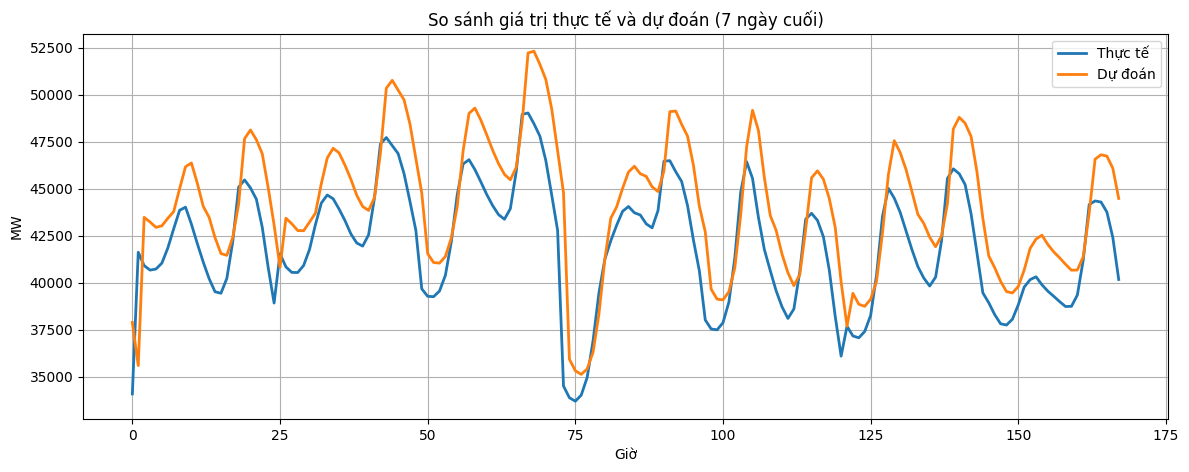

In [29]:
import matplotlib.pyplot as plt
test_df = df_model[-(24*7 + SEQ_LEN + TARGET_SHIFT):].reset_index(drop=True)
test_dataset = TimeSeriesDataset(test_df, SEQ_LEN, TARGET_SHIFT)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x)
        predictions.append(pred.item())
        actuals.append(y.item())
pred_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actual_inv = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

plt.figure(figsize=(14, 5))
plt.plot(actual_inv, label='Thực tế', linewidth=2)
plt.plot(pred_inv, label='Dự đoán', linewidth=2)
plt.title('So sánh giá trị thực tế và dự đoán (7 ngày cuối)')
plt.xlabel('Giờ')
plt.ylabel('MW')
plt.legend()
plt.grid(True)
plt.show()
